## 2015-2016


Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992885.46, value end = $ 1020213.53
  Strategy "Mininum Variance Portfolio", value begin = $ 991486.27, value end = $ 1016590.39
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990102.05, value end = $ 1007783.53
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 992763.14, value end = $ 1018719.44
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 985526.24, value end = $ 1037596.04
  Strategy "Robust Optimization Portfolio", value begin = $ 991959.22, value end = $ 1000224.39

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030883.39, value end = $ 1011331.55
  Strategy "

  Strategy "Mininum Variance Portfolio", value begin = $ 1007670.79, value end = $ 1121429.91
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1156835.09, value end = $ 1533327.16
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1134202.85, value end = $ 1244087.53
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1218296.95, value end = $ 1433086.18
  Strategy "Robust Optimization Portfolio", value begin = $ 1040509.28, value end = $ 1126709.82


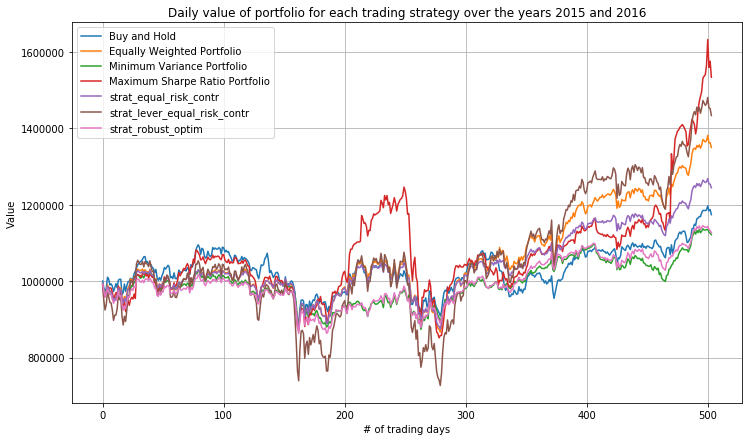

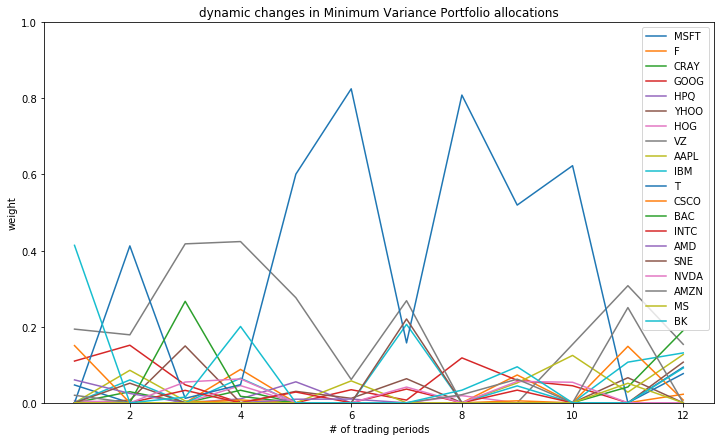

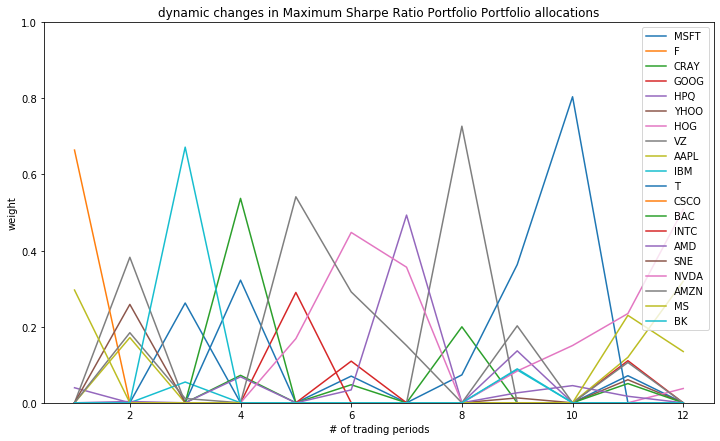

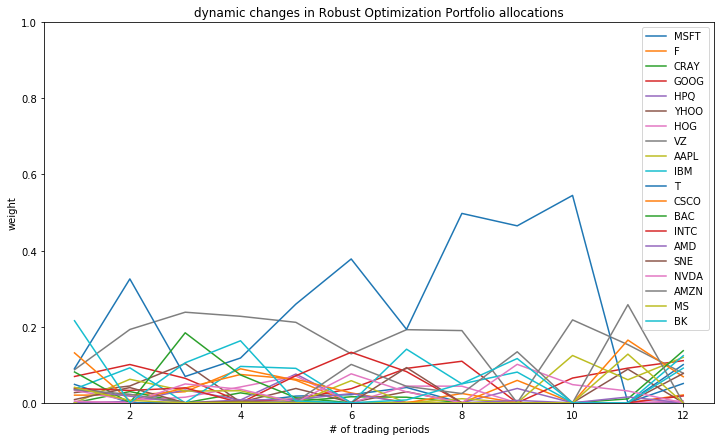

In [56]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import ipopt
import cvxpy as cp
import matplotlib.pyplot as plt
# Complete the following functions
data = [[],[],[],[],[],[],[]]
mv = []
ms = []
ro = []
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    w_i = 1/len(x_init)
    V = np.sum(cur_prices * x_init) + cash_init
    #x_i=V*w_i/v_i, where w_i=1/20, so we have x_i=V/(20*v_i), and // is use for rounding down
    x_optimal = V * w_i // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    #To make sure cash is non-negative
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = V_new * w_i // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    # Calculate portfolio value。
    V = np.sum(cur_prices * x_init) + cash_init
    # number of stocks is 20.
    n = 20
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    w = []
    A = []
    for k in range(n):
        A.append([[0],[1.0]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    w_frontC = []
    var_frontC = []
    ret_frontC = []
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()
    numcols = cpx.variables.get_num()
    for j in range(numcols):
        w.append(cpx.solution.get_values(j))
    w_cur = np.asarray(w)
    x_optimal = w_cur * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = np.array(w_cur) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    V = np.sum(cur_prices * x_init) + cash_init
    n = 20
    c  = [0.0] * (n+1)
    lb = [0.0] * (n+1)
    ub = [cplex.infinity] * (n+1)
    y = []
    A = []
    for k in range(n):
        # r_rf/252 is daily risk free rate.
        A.append([[0, 1],[mu[k] - r_rf/252, 1]])
    # append -1 as a coefficient of k. since the second constraint has 21 variables in lhs 
    # while the first constraint has only 20 variables in lhs, append 0 as a coefficient to the first constraint.
    A.append([[0, 1],[0.0, -1]])
    var_names = ["w_%s" % i for i in range(1,n+2)]
    cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    # Add 0 at the end of Qmat
    Qmat.append([[0], [0.0]])
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    w_frontC = []
    var_frontC = []
    ret_frontC = []
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()
    numcols = cpx.variables.get_num()
    for j in range(numcols):
        y.append(cpx.solution.get_values(j))
    y_cur = np.asarray(y)
    # w=y/k where k is the last index of y_cur
    w_cur = y_cur[:-1]/y_cur[-1]
    x_optimal = np.array(w_cur) * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = np.array(w_cur) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    w_init = np.ones(n)/n
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            # Insert your gradient computations here
            # You can use finite differences to check the gradient
            g = np.dot(Q, x)
            f = x * g
            grad = np.zeros(n)
            for i in range(n):
                list1 = list(range(0,i)) + list(range(i+1,n))
                for j in list1:
                    grad[i] += 4 * (f[i]-f[j]) * (g[i]-Q[j,i]*x[j]+Q[i,i]*x[i])
                for k in list1:
#                     list2 = list(range(0,k)) + list(range(k+1, list1[-1]))
                    for l in range(k+1, list1[-1]):
                        grad[i] += 4 * (f[k]-f[l]) * (Q[k,i]*x[k]-Q[l,i]*x[l])
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])

        def intermediate(
                self,
                alg_mod,
                iter_count,
                obj_value,
                inf_pr,
                inf_du,
                mu,
                d_norm,
                regularization_size,
                alpha_du,
                alpha_pr,
                ls_trials
                ):

            # Example for the use of the intermediate callback.
            #print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))
            return
    V = np.sum(cur_prices * x_init) + cash_init
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w_init), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    # Solve the problem
    w_erc, info = nlp.solve(w_init)

    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    x_optimal = w_erc * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = np.array(w_erc) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)

    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    w_init = np.ones(n)/n
    V = np.sum(cur_prices * x_init) + cash_init
    long = init_value
    if period == 1:
        V = np.sum(cur_prices * x_init) + cash_init + long

    else:
        V = np.sum(cur_prices * x_init) + cash_init
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            g = np.dot(Q, x)
            f = x * g
            grad = np.zeros(n)
            for i in range(n):
                list1 = list(range(0,i)) + list(range(i+1,n))
                for j in list1:
                    grad[i] += 4 * (f[i]-f[j]) * (g[i]-Q[j,i]*x[j]+Q[i,i]*x[i])
                for k in list1:
                    for l in range(k+1, list1[-1]):
                        grad[i] += 4 * (f[k]-f[l]) * (Q[k,i]*x[k]-Q[l,i]*x[l])
            # Insert your     gradient computations here
            # You can use finite differences to check the gradient
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])

        def intermediate(
                self,
                alg_mod,
                iter_count,
                obj_value,
                inf_pr,
                inf_du,
                mu,
                d_norm,
                regularization_size,
                alpha_du,
                alpha_pr,
                ls_trials
                ):
            return
            # Example for the use of the intermediate callback.
            #print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))

    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w_init), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    # Solve the problem
    w_erc, info = nlp.solve(w_init)
    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    x_optimal = w_erc * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f + (long*r_rf/6))
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
       
        x_optimal = np.array(w_erc) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f + (long*r_rf/6))
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    w_init = np.ones(n)/n
    Portf_Retn = np.dot(mu, w_init)
    var_matr = np.diag(np.diag(Q))
    rob_bnd = np.dot(w_init, np.dot(var_matr, w_init))
    cpx = cplex.Cplex()
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
#     print("Setting number of threads = ", 4)
    cpx.parameters.timelimit.set(60)
#     print("Setting timelimit = ", 60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
#     print("Setting Barrier algorithm convergence tolerance = ", 1e-12)
    
    cpx.solve()
    w_rMV = cpx.solution.get_values()
    w_rMV = np.array(w_rMV)
    V = np.sum(cur_prices * x_init) + cash_init
    x_optimal = w_rMV * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = np.array(w_rMV) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
 
    # Execute portfolio selection strategies
    for strategy in range(N_strat):

        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
    

        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################

        # Compute portfolio value
        if strategy == 5:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1] - init_value
        else:
            p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        data[strategy] += list(p_values)
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
            portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        if strategy == 2:
            # append weight of each stock by period
            mv.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
        # maximum sharpe ratio strategy
        if strategy == 3:
            # append weight of each stock by period
            if np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1]) == 0:
                ms.append(np.zeros(20))
            else:
                ms.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
        # robust mean variance strategy
        if strategy == 6:
            # append weight of each stock by period
            ro.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################
plt.figure(figsize=(12,7))
plt.plot(data[0], label = 'Buy and Hold')
plt.plot(data[1], label = 'Equally Weighted Portfolio')
plt.plot(data[2], label = 'Minimum Variance Portfolio')
plt.plot(data[3], label = 'Maximum Sharpe Ratio Portfolio')
plt.plot(data[4], label = 'strat_equal_risk_contr')
plt.plot(data[5], label = 'strat_lever_equal_risk_contr')
plt.plot(data[6], label = 'strat_robust_optim')
plt.title('Daily value of portfolio for each trading strategy over the years 2015 and 2016')
plt.xlabel('# of trading days')
plt.ylabel('Value')
plt.grid(True)
plt.legend(loc='best')
plt.figure(figsize=(12,7))
for i in range(20):
    # Take transpose of mv to have weight by each stock in all period.
    plt.plot(range(1, 13), np.asarray(mv).T[i].reshape(-1,1), label = list(df.columns)[i+1])
    plt.ylim(0, 1)
    plt.title('dynamic changes in Minimum Variance Portfolio allocations')
    plt.xlabel('# of trading periods')
    plt.ylabel('weight')
    plt.legend(loc='best')
plt.figure(figsize=(12,7))
for i in range(20):
    # Take transpose of mv to have weight by each stock in all period.
    plt.plot(range(1, 13), np.asarray(ms).T[i].reshape(-1,1), label = list(df.columns)[i+1])
    plt.ylim(0, 1)
    plt.title('dynamic changes in Maximum Sharpe Ratio Portfolio Portfolio allocations')
    plt.xlabel('# of trading periods')
    plt.ylabel('weight')
    plt.legend(loc='best')
plt.figure(figsize=(12,7))
for i in range(20):
    # Take transpose of mv to have weight by each stock in all period.
    plt.plot(range(1, 13), np.asarray(ro).T[i].reshape(-1,1), label = list(df.columns)[i+1])
    plt.ylim(0, 1)
    plt.title('dynamic changes in Robust Optimization Portfolio allocations')
    plt.xlabel('# of trading periods')
    plt.ylabel('weight')
    plt.legend(loc='best')


## 2008-2009


Initial portfolio value = $ 548247.97


Period 1: start date 1/2/2008, end date 2/29/2008
  Strategy "Buy and Hold", value begin = $ 548247.97, value end = $ 465217.72
  Strategy "Equally Weighted Portfolio", value begin = $ 544335.07, value end = $ 470649.09
  Strategy "Mininum Variance Portfolio", value begin = $ 543936.52, value end = $ 462375.59
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 542820.44, value end = $ 474310.32
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 544302.72, value end = $ 472303.91
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 538804.96, value end = $ 394679.08
  Strategy "Robust Optimization Portfolio", value begin = $ 544639.09, value end = $ 472240.46

Period 2: start date 3/3/2008, end date 4/30/2008
  Strategy "Buy and Hold", value begin = $ 462553.95, value end = $ 511257.48
  Strategy "Equally Weighted Portfolio", value begin = $ 464358.58, value end = $ 510964.38
  Strategy "Mininum Varia

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 276158.36, value end = $ 312353.71
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 468303.23, value end = $ 523927.47
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 312401.92, value end = $ 414707.52
  Strategy "Robust Optimization Portfolio", value begin = $ 472734.38, value end = $ 526316.75


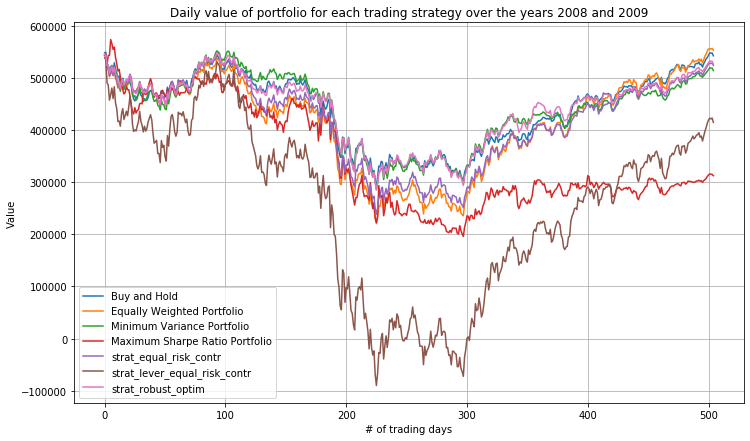

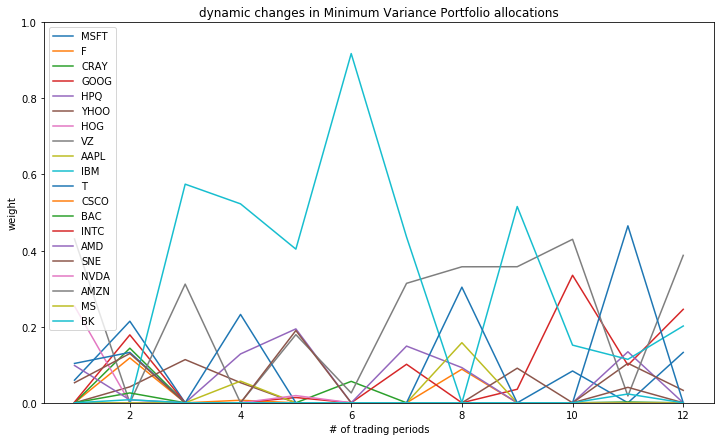

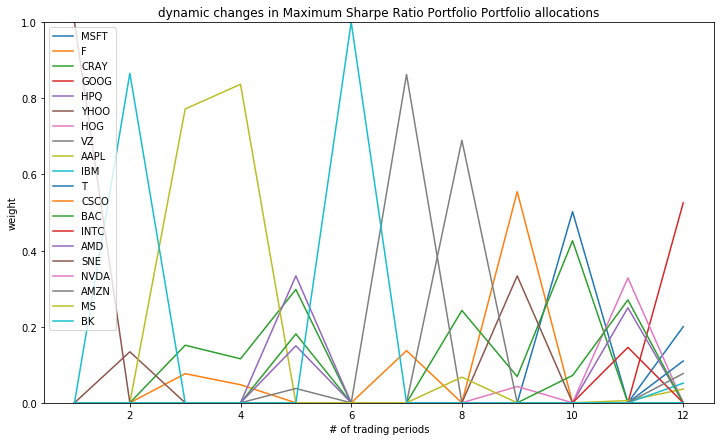

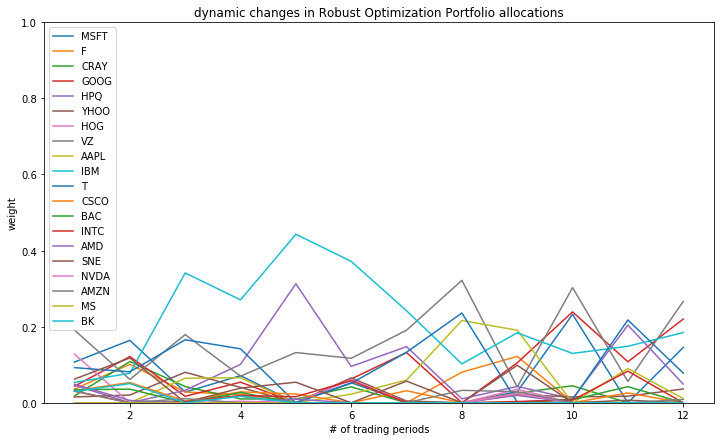

In [53]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import ipopt
import cvxpy as cp
import matplotlib.pyplot as plt
# Complete the following functions
data = [[],[],[],[],[],[],[]]
mv = []
ms = []
ro = []
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    w_i = 1/len(x_init)
    V = np.sum(cur_prices * x_init) + cash_init
    #x_i=V*w_i/v_i, where w_i=1/20, so we have x_i=V/(20*v_i), and // is use for rounding down
    x_optimal = V * w_i // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    #To make sure cash is non-negative
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = V_new * w_i // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    # Calculate portfolio value。
    V = np.sum(cur_prices * x_init) + cash_init
    # number of stocks is 20.
    n = 20
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    w = []
    A = []
    for k in range(n):
        A.append([[0],[1.0]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E")

    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    w_frontC = []
    var_frontC = []
    ret_frontC = []
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()
    numcols = cpx.variables.get_num()
    for j in range(numcols):
        w.append(cpx.solution.get_values(j))
    w_cur = np.asarray(w)
    x_optimal = w_cur * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = np.array(w_cur) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    V = np.sum(cur_prices * x_init) + cash_init
    if sum(i > 0 for i in mu-r_rf2008_2009/252) > 0:
        cpx = cplex.Cplex()
        cpx.objective.set_sense(cpx.objective.sense.minimize)
        n = 20
        c  = [0.0] * (n+1)
        lb = [0.0] * (n+1)
        ub = [cplex.infinity] * (n+1)
        y = []
        A = []
        for k in range(n):
            # r_rf/252 is daily risk free rate.
            A.append([[0, 1],[mu[k] - r_rf2008_2009/252, 1]])
        # append -1 as a coefficient of k. since the second constraint has 21 variables in lhs 
        # while the first constraint has only 20 variables in lhs, append 0 as a coefficient to the first constraint.
        A.append([[0, 1],[0.0, -1]])
        var_names = ["w_%s" % i for i in range(1,n+2)]
        cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")

        cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)

        Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
        # Add 0 at the end of Qmat
        Qmat.append([[0], [0.0]])
        cpx.objective.set_quadratic(Qmat)
        cpx.parameters.threads.set(4)
        cpx.set_results_stream(None)
        cpx.set_warning_stream(None)
        w_frontC = []
        var_frontC = []
        ret_frontC = []
        alg = cpx.parameters.lpmethod.values
        cpx.parameters.qpmethod.set(alg.concurrent)
        cpx.solve()
        numcols = cpx.variables.get_num()
        for j in range(numcols):
            y.append(cpx.solution.get_values(j))
        y_cur = np.asarray(y)
        # w=y/k where k is the last index of y_cur
        w_cur = y_cur[:-1]/y_cur[-1]
        x_optimal = np.array(w_cur) * V // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
        if cash_optimal < 0:
            #V add negative cash to have non-negative cash
            V_new = V + cash_optimal - t_f
            x_optimal = np.array(w_cur) * V_new // cur_prices
            t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
            cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
        if cash_optimal < 0:
            print('cash is negative')
    else:
        x_optimal = x_init
        cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    w_init = np.ones(20)/20
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            # Insert your gradient computations here
            # You can use finite differences to check the gradient
            g = np.dot(Q, x)
            f = x * g
            grad = np.zeros(n)
            for i in range(n):
                list1 = list(range(0,i)) + list(range(i+1,n))
                for j in list1:
                    grad[i] += 4 * (f[i]-f[j]) * (g[i]-Q[j,i]*x[j]+Q[i,i]*x[i])
                for k in list1:
                    for l in range(k+1, list1[-1]):
                        grad[i] += 4 * (f[k]-f[l]) * (Q[k,i]*x[k]-Q[l,i]*x[l])
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])

        def intermediate(
                self,
                alg_mod,
                iter_count,
                obj_value,
                inf_pr,
                inf_du,
                mu,
                d_norm,
                regularization_size,
                alpha_du,
                alpha_pr,
                ls_trials
                ):

            # Example for the use of the intermediate callback.
            #print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))
            return
    V = np.sum(cur_prices * x_init) + cash_init
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w_init), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    # Solve the problem
    w_erc, info = nlp.solve(w_init)

    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
#     print(RC_ERC)
    x_optimal = w_erc * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = np.array(w_erc) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)

    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    w_init = np.ones(20)/20
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            g = np.dot(Q, x)
            f = x * g
            grad = np.zeros(n)
            for i in range(n):
                list1 = list(range(0,i)) + list(range(i+1,n))
                for j in list1:
                    grad[i] += 4 * (f[i]-f[j]) * (g[i]-Q[j,i]*x[j]+Q[i,i]*x[i])
                for k in list1:
                    for l in range(k+1, list1[-1]):
                        grad[i] += 4 * (f[k]-f[l]) * (Q[k,i]*x[k]-Q[l,i]*x[l])
            # Insert your gradient computations here
            # You can use finite differences to check the gradient
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n

        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])

        def intermediate(
                self,
                alg_mod,
                iter_count,
                obj_value,
                inf_pr,
                inf_du,
                mu,
                d_norm,
                regularization_size,
                alpha_du,
                alpha_pr,
                ls_trials
                ):
            return
            # Example for the use of the intermediate callback.
            #print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))
    long = np.sum(cur_prices * x_init) + cash_init
    if period == 1:
        V = np.sum(cur_prices * x_init) + cash_init + long
    else:
        V = np.sum(cur_prices * x_init) + cash_init
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w_init), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    # Solve the problem
    w_erc, info = nlp.solve(w_init)
    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    x_optimal = w_erc * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f + long*r_rf2008_2009/6)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = np.array(w_erc) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f + long*r_rf2008_2009/6)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    w_init = np.ones(n)/n
#     Portf_Retn = r_rf2008_2009/252
    var_matr = np.diag(np.diag(Q))
    Portf_Retn = np.dot(mu, w_init)
    rob_bnd = np.dot(w_init, np.dot(var_matr, w_init)) 
    cpx = cplex.Cplex()
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
#     print("Setting number of threads = ", 4)
    cpx.parameters.timelimit.set(60)
#     print("Setting timelimit = ", 60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
#     print("Setting Barrier algorithm convergence tolerance = ", 1e-12)
    
    cpx.solve()
    w_rMV = cpx.solution.get_values()
    w_rMV = np.array(w_rMV)
    V = np.sum(cur_prices * x_init) + cash_init
    x_optimal = w_rMV * V // cur_prices
    t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
    cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        #V add negative cash to have non-negative cash
        V_new = V + cash_optimal - t_f
        x_optimal = np.array(w_rMV) * V_new // cur_prices
        t_f = 0.005 * np.sum(cur_prices * np.abs(x_optimal - x_init))
        cash_optimal = V - (np.sum(cur_prices * x_optimal) + t_f)
    if cash_optimal < 0:
        print('cash is negative')
    return x_optimal, cash_optimal

# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 15:
       cur_year  = 15 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
    

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # Compute portfolio value
      if strategy == 5:
          p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1] - init_value
      else:
          p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      data[strategy] += list(p_values)
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      # minimum variance strategy
      if strategy == 2:
          # append weight of each stock by period
          mv.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
      # maximum sharpe ratio strategy
      if strategy == 3:
          # append weight of each stock by period
          if np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1]) == 0:
              ms.append(np.zeros(20))
          else:
              ms.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
      # robust minimum variance strategy
      if strategy == 6:
          # append weight of each stock by period
          ro.append(list(data_prices[day_ind_start:day_ind_end+1,:][0] * x[strategy, period-1]/np.dot(data_prices[day_ind_start:day_ind_end+1,:][0], x[strategy, period-1])))
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################
plt.figure(figsize=(12,7))
plt.plot(data[0], label = 'Buy and Hold')
plt.plot(data[1], label = 'Equally Weighted Portfolio')
plt.plot(data[2], label = 'Minimum Variance Portfolio')
plt.plot(data[3], label = 'Maximum Sharpe Ratio Portfolio')
plt.plot(data[4], label = 'strat_equal_risk_contr')
plt.plot(data[5], label = 'strat_lever_equal_risk_contr')
plt.plot(data[6], label = 'strat_robust_optim')
plt.title('Daily value of portfolio for each trading strategy over the years 2008 and 2009')
plt.xlabel('# of trading days')
plt.ylabel('Value')
plt.grid(True)
plt.legend(loc='best')
plt.figure(figsize=(12,7))
for i in range(20):
    # Take transpose of mv to have weight by each stock in all period.
    plt.plot(range(1, 13), np.asarray(mv).T[i].reshape(-1,1), label = list(df.columns)[i+1])
    plt.ylim(0, 1)
    plt.title('dynamic changes in Minimum Variance Portfolio allocations')
    plt.xlabel('# of trading periods')
    plt.ylabel('weight')
    plt.legend(loc='best')
plt.figure(figsize=(12,7))
for i in range(20):
    # Take transpose of mv to have weight by each stock in all period.
    plt.plot(range(1, 13), np.asarray(ms).T[i].reshape(-1,1), label = list(df.columns)[i+1])
    plt.ylim(0, 1)
    plt.title('dynamic changes in Maximum Sharpe Ratio Portfolio Portfolio allocations')
    plt.xlabel('# of trading periods')
    plt.ylabel('weight')
    plt.legend(loc='best')
plt.figure(figsize=(12,7))
for i in range(20):
    # Take transpose of mv to have weight by each stock in all period.
    plt.plot(range(1, 13), np.asarray(ro).T[i].reshape(-1,1), label = list(df.columns)[i+1])
    plt.ylim(0, 1)
    plt.title('dynamic changes in Robust Optimization Portfolio allocations')
    plt.xlabel('# of trading periods')
    plt.ylabel('weight')
    plt.legend(loc='best')
